In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.metrics import v_measure_score
from sklearn.metrics import silhouette_score

from sklearn.cluster import KMeans
!pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score



In [2]:
train_df=pd.read_csv('mitbih_train.csv',header=None)
test_df=pd.read_csv('mitbih_test.csv',header=None)

c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

In [3]:
print(train_df.shape)
print(test_df.shape)

(87554, 188)
(21892, 188)


In [4]:
#garder uniquement 10'000 lignes de train_df
train_df=train_df.sample(10000)
print(train_df.shape)
print(test_df.shape)

(10000, 188)
(21892, 188)


c:\Users\antho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


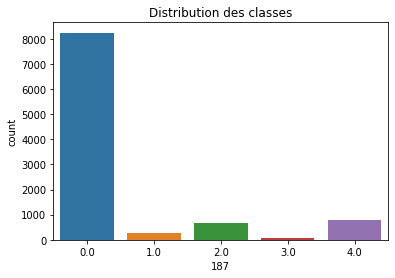

In [5]:
#montrer la distribution des classes
sns.countplot(train_df[187])
plt.title('Distribution des classes')
plt.show()

# Histogramm de la répartition

In [6]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)
test_df[187]=test_df[187].astype(int)
equilibre_test=test_df[187].value_counts()
print(equilibre_test)


0    8245
4     733
2     659
1     283
3      80
Name: 187, dtype: int64
0    18118
4     1608
2     1448
1      556
3      162
Name: 187, dtype: int64


affichage de la répartition par classe 

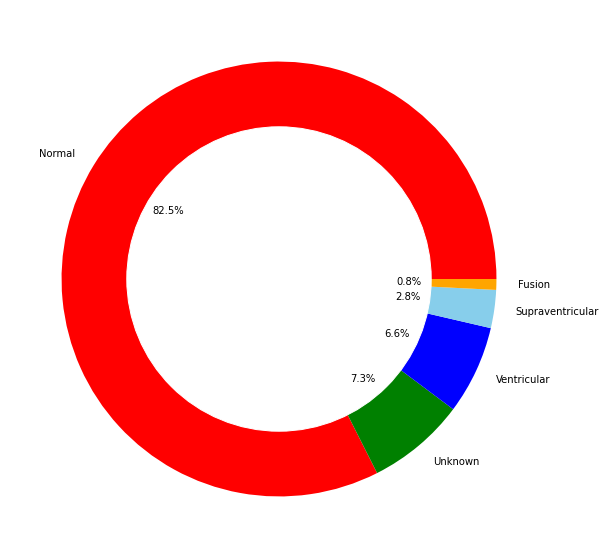

In [7]:
#-N : Non-ecotic beats (normal beat)
# -S : Supraventricular ectopic beats
# -V : Ventricular ectopic beats
# -F : Fusion Beats
# -Q : Unknown Beats
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['Normal','Unknown','Ventricular','Supraventricular','Fusion'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hist(class_number, size, min_, bins):
    img = train_df.loc[train_df[187] == class_number].values
    img = img[:, min_:size]
    img_flatten = img.flatten()

    final1 = np.arange(min_, size)
    for i in range(img.shape[0] - 1):
        tempo1 = np.arange(min_, size)
        final1 = np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    
    plt.hist2d(final1, img_flatten, bins=(bins, bins), cmap=plt.cm.jet)
    plt.colorbar() # Ajoute une barre de couleur pour mieux visualiser les intensités
    plt.clim(0, np.max(img_flatten)) # Ajuste la plage de couleurs pour améliorer le contraste
    plt.show()



1533570
1533570


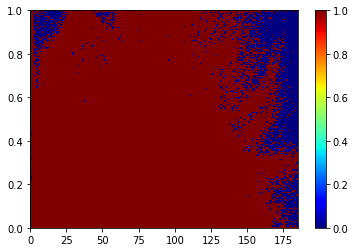

In [9]:
plot_hist(0, 186, 0, 186)

52638
52638


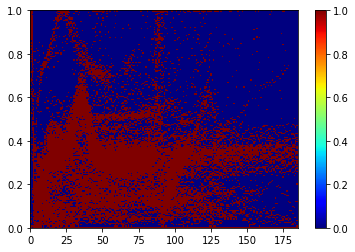

In [10]:
plot_hist(1, 186, 0, 186)

122574
122574


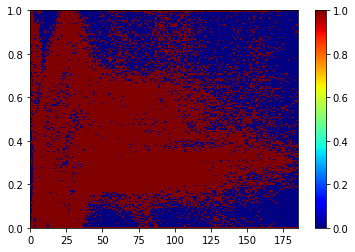

In [11]:
plot_hist(2, 186, 0, 186)

14880
14880


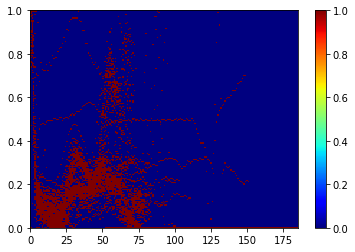

In [12]:
plot_hist(3, 186, 0, 186)

136338
136338


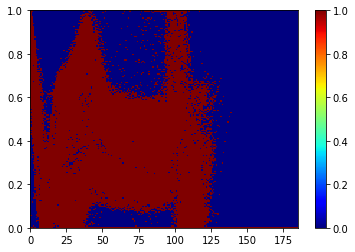

In [13]:
plot_hist(4, 186, 0, 186)

# Pre traitement

### Rééquilibrage ?

### Stockage des cibles

In [7]:
y_train=train_df[187].values
y_test=test_df[187].values

### Ajout de bruit ?

### Normalisation

In [8]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values

# Scale time series
scaler = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_2D = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_test_scaled_2D = X_test_scaled.reshape(X_test_scaled.shape[0], -1)



X_train_r = X_train.reshape(len(X_train), X_train.shape[1])
X_test_r = X_test.reshape(len(X_test), X_test.shape[1])


TimeSeriesScalerMeanVariance prends en comptes les caractéristiques uniques des données de séries temporelles. (ce que ne fait pas un simple reshape) Ainsi, chaque série temp. contribue de manière égale à l'algorithme de regroupement

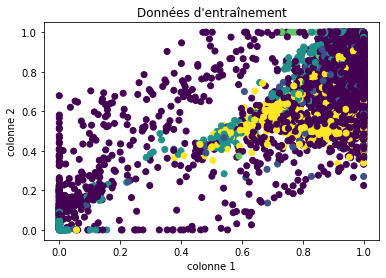

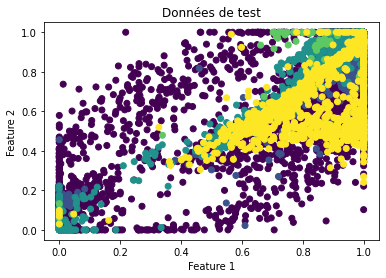

In [9]:
# Affichage des données d'entraînement
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.xlabel('colonne 1')
plt.ylabel('colonne 2')
plt.title('Données d\'entraînement')
plt.show()

# Affichage des données de test
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Données de test')
plt.show()

On peut voir que les regroupements sont difficiles pour ces données. 

# Clustering KMeans

In [38]:


# définir le nombre de clusters
n_clusters = 5

# Initialiser le modèle KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Entraîner le modèle sur les données d'entraînement
kmeans.fit(X_train_r)

# Prédire les clusters pour les données de test
y_pred = kmeans.predict(X_test_r)

# Evaluer la performance en utilisant l'indice d'adjacent V-measure

v_measure = v_measure_score(y_test, y_pred)
print("V-measure:", v_measure)


# Calcul de l'indice de Rand ajusté
ari = adjusted_rand_score(y_test, y_pred)

print("Indice de Rand ajusté :", ari)

V-measure: 0.08790169983995388
Indice de Rand ajusté : 0.09785008284332963


0.088 indique que les clusters formés ne sont pas très performants et qu'il est nécessaire de faire des ajustements supplémentaires pour améliorer la qualité du clustering. 0 min, 1 max pour des clusters parfait

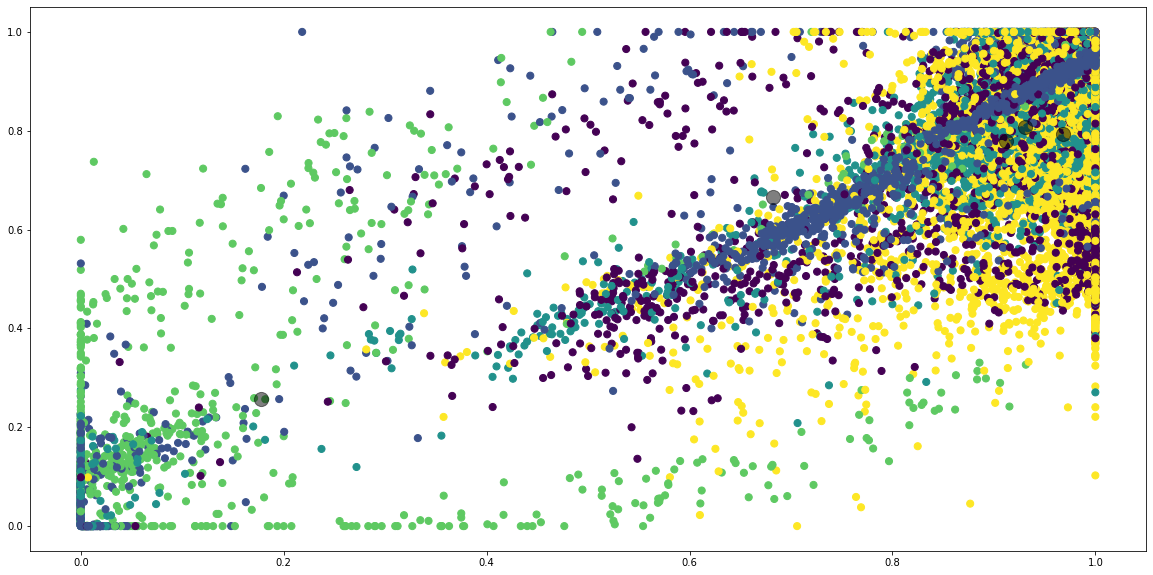

In [30]:
#plot the clusters
plt.figure(figsize=(20,10))
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()


In [31]:
# Évaluer les résultats avec le score de silhouette
silhouette_score_init = silhouette_score(X_test, y_pred)
print("Score de silhouette initial:",silhouette_score_init)

Score de silhouette initial: 0.17773763423061312


Pour la métrique silhouette, le min est -1 et le max 1. Plus le score est proche de 1, plus les clusters sont bien définis. Ici, le score initiale est 0.18.

In [32]:
#calculer le pourcentage de données mal classées
y_pred=kmeans.predict(X_test)
misclassified_samples=np.where(y_pred!=y_test)[0]
print("Pourcentage de données mal classées:",len(misclassified_samples)/len(y_test)*100)

Pourcentage de données mal classées: 85.16809793531884


In [39]:
def correct_clustering_percentage(conf_mat):
    # Sum the maximum values in each row (i.e., the largest cluster for each class)
    correct_clustering = np.sum(np.amax(conf_mat, axis=1))

    # Calculate the total number of samples
    total_samples = np.sum(conf_mat)

    # Calculate the correct clustering percentage
    correct_clustering_percentage = correct_clustering / total_samples * 100

    return correct_clustering_percentage


def percentage_with_diag(conf_mat):
    # Calculate the correct clustering percentage using the diagonal elements
    correct_clustering_percentage_diag = np.sum(np.diag(conf_mat)) / np.sum(conf_mat) * 100

    return correct_clustering_percentage_diag

from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion matrix:")
print(conf_mat)

# Calculate and print the correct clustering percentage
print("Correct clustering percentage:", correct_clustering_percentage(conf_mat))

# Calculate and print the correct clustering percentage using the diagonal elements
print("Percentage with diag:", percentage_with_diag(conf_mat))


Confusion matrix:
[[2647  872 4590  731 9278]
 [ 140   25  231    5  155]
 [ 418  280  282  115  353]
 [   0    1   44    1  116]
 [ 368  868   79    1  292]]
Correct clustering percentage: 49.840124246300014
Percentage with diag: 14.831902064681163


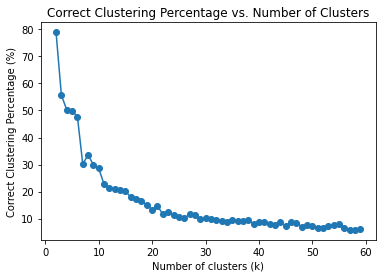

Optimal k value (based on correct clustering percentage): 2
Confusion matrix:
[[ 3194 14924     0     0     0]
 [  189   367     0     0     0]
 [  582   866     0     0     0]
 [    3   159     0     0     0]
 [  968   640     0     0     0]]
Correct clustering percentage: 78.95121505572811
Percentage with diag: 16.266215969303854


In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Prepare your data
# X_train_r and X_test_r from your previous code

# Determine the range of k values to test
k_values = range(2, 60)  # Test k values from 2 to 29

# Calculate the correct clustering percentage for each k value
correct_clustering_percentages = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_train_r)
    y_pred = kmeans.predict(X_test_r)
    conf_mat = confusion_matrix(y_test, y_pred)
    correct_clustering_percentage_k = correct_clustering_percentage(conf_mat)
    correct_clustering_percentages.append(correct_clustering_percentage_k)

# Plot the correct clustering percentages for different k values
plt.plot(k_values, correct_clustering_percentages, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Correct Clustering Percentage (%)')
plt.title('Correct Clustering Percentage vs. Number of Clusters')
plt.show()

# Find the optimal k value with the highest correct clustering percentage
optimal_k_correct_clustering = k_values[correct_clustering_percentages.index(max(correct_clustering_percentages))]
print("Optimal k value (based on correct clustering percentage):", optimal_k_correct_clustering)

# Train the KMeans model with the optimal k value
kmeans_optimal = KMeans(n_clusters=optimal_k_correct_clustering, random_state=0)
kmeans_optimal.fit(X_train_r)
y_pred_optimal = kmeans_optimal.predict(X_test_r)

# Calculate the confusion matrix for the optimal k value
conf_mat_optimal = confusion_matrix(y_test, y_pred_optimal)

# Print the confusion matrix
print("Confusion matrix:")
print(conf_mat_optimal)

# Calculate and print the correct clustering percentage
print("Correct clustering percentage:", correct_clustering_percentage(conf_mat_optimal))

# Calculate and print the correct clustering percentage using the diagonal elements
print("Percentage with diag:", percentage_with_diag(conf_mat_optimal))


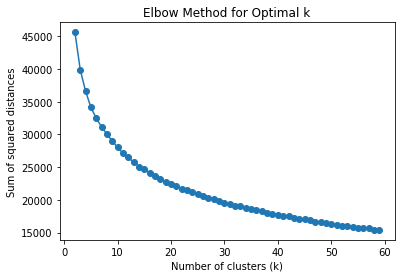

Optimal k value: 59
Optimal k value (based on silhouette score): 2


In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Prepare your data
# X_train_r and X_test_r from your previous code

# Determine the range of k values to test
k_values = range(2, 60)  # Test k values from 1 to 10

# Calculate the sum of squared distances for each k value
sum_of_squared_distances = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_train_r)
    sum_of_squared_distances.append(kmeans.inertia_)
    if k > 1:  # Silhouette score requires at least 2 clusters
        silhouette_scores.append(silhouette_score(X_test_r, kmeans.predict(X_test_r)))
    else:
        silhouette_scores.append(float('-inf'))

# Plot the elbow curve
plt.plot(k_values, sum_of_squared_distances, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.show()

# Find the optimal k value based on the elbow method
optimal_k = k_values[sum_of_squared_distances.index(min(sum_of_squared_distances[1:]))]
print("Optimal k value:", optimal_k)

# Find the optimal k value based on the silhouette score
optimal_k_silhouette = k_values[silhouette_scores.index(max(silhouette_scores))]
print("Optimal k value (based on silhouette score):", optimal_k_silhouette)


# Clustering KMeans temp - euclidean

In [40]:
# Time Series KMeans Clustering
n_clusters = 5
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", random_state=0)

# Fit the model on the training data
ts_kmeans.fit(X_train_scaled)

# Predict the clusters for the test data
y_pred = ts_kmeans.predict(X_test_scaled)

# Evaluate the results using the silhouette score
silhouette_score_tskmeans = silhouette_score(X_test_scaled.reshape(X_test.shape[0], -1), y_pred)
print("Silhouette score for Time Series KMeans:", silhouette_score_tskmeans)

# Calculating the percentage of misclassified data
misclassified_samples = np.where(y_pred != y_test)[0]
print("Percentage of misclassified data:", len(misclassified_samples) / len(y_test) * 100)

v_measure = v_measure_score(y_test, y_pred)
print("V-measure:", v_measure)

# Calcul de l'indice de Rand ajusté
ari = adjusted_rand_score(y_test, y_pred)

print("Indice de Rand ajusté :", ari)


Silhouette score for Time Series KMeans: 0.12122088328916432
Percentage of misclassified data: 83.80230221085327
V-measure: 0.07427501506899592
Indice de Rand ajusté : 0.01310568799835681


In [41]:

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion matrix:")
print(conf_mat)

# Calculate and print the correct clustering percentage
print("Correct clustering percentage:", correct_clustering_percentage(conf_mat))

# Calculate and print the correct clustering percentage using the diagonal elements
print("Percentage with diag:", percentage_with_diag(conf_mat))


Confusion matrix:
[[3065 3222 2867 4375 4589]
 [ 152  213   21   29  141]
 [ 366  416  220  115  331]
 [   7    2    0   10  143]
 [   1 1008  542   19   38]]
Correct clustering percentage: 29.09281929471953
Percentage with diag: 16.19769778914672


# Clustering KMeans temp - dtw

dtw est une autre métrique qui prend en compte les décalages temporels entre les séries temporelles.

In [42]:
n_clusters = 5
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)

# Fit the model on the training data
ts_kmeans.fit(X_train_scaled)   

# Predict the clusters for the test data
y_pred = ts_kmeans.predict(X_test_scaled)

silhouette_score_tskmeans = silhouette_score(X_test_scaled.reshape(X_test.shape[0], -1), y_pred)
print("Silhouette score for Time Series KMeans:", silhouette_score_tskmeans)

# Calculating the percentage of misclassified data
misclassified_samples = np.where(y_pred != y_test)[0]
print("Percentage of misclassified data:", len(misclassified_samples) / len(y_test) * 100)

v_measure = v_measure_score(y_test, y_pred)
print("V-measure:", v_measure)


Silhouette score for Time Series KMeans: 0.012289252159019137
Percentage of misclassified data: 88.54376027772702
V-measure: 0.09249045048834852


In [43]:
# Calcul de l'indice de Rand ajusté
ari = adjusted_rand_score(y_test, y_pred)

print("Indice de Rand ajusté :", ari)

Indice de Rand ajusté : 0.0816877904461087


In [44]:

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion matrix:")
print(conf_mat)

# Calculate and print the correct clustering percentage
print("Correct clustering percentage:", correct_clustering_percentage(conf_mat))

# Calculate and print the correct clustering percentage using the diagonal elements
print("Percentage with diag:", percentage_with_diag(conf_mat))

Confusion matrix:
[[1975 7877 5335 2047  884]
 [ 120  165  174   91    6]
 [ 315   93  361  324  355]
 [   4   80   76    0    2]
 [1064   85  373   79    7]]
Correct clustering percentage: 43.650648638772154
Percentage with diag: 11.456239722272976


In [29]:
print("Pourcentage de données mal classées en tenant compte des clusters les plus grands:", calculate_misclassification_rate(y_pred, y_test))

Pourcentage de données mal classées en tenant compte des clusters les plus grands: 17.239174127535172


# Clustering DBSCAN

In [57]:
# Initialize the DBSCAN model
dbscan = DBSCAN(eps=0.3, min_samples=10)

# Fit the model to the data
dbscan.fit(X_train_r)

# Predict the cluster labels for the test data
y_pred = dbscan.fit_predict(X_test_r)

# Evaluer la performance en utilisant l'indice d'adjacent V-measure
v_measure = v_measure_score(y_test, y_pred)
print("V-measure:", v_measure)

# Evaluate the results using the silhouette score
silhouette_score_init = silhouette_score(X_test_r, y_pred)
print("Score de silhouette initial avec DBSCAN:", silhouette_score_init)

# Calculating the percentage of misclassified data
misclassified_samples = np.where(y_pred != y_test)[0]
print("Percentage of misclassified data:", len(misclassified_samples) / len(y_test) * 100)

# Calcul de l'indice de Rand ajusté
ari = adjusted_rand_score(y_test, y_pred)

print("Indice de Rand ajusté :", ari)


V-measure: 0.03328812026903625
Score de silhouette initial avec DBSCAN: -0.30481196525023657
Percentage of misclassified data: 98.2733418600402
Indice de Rand ajusté : -0.13054677936602122


In [58]:

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion matrix:")
print(conf_mat)

# Calculate and print the correct clustering percentage
print("Correct clustering percentage:", correct_clustering_percentage(conf_mat))

# Calculate and print the correct clustering percentage using the diagonal elements
print("Percentage with diag:", percentage_with_diag(conf_mat))

Confusion matrix:
[[    0     0     0 ...     0     0     0]
 [15668   375   146 ...    10    13    10]
 [  556     0     0 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]
Correct clustering percentage: 88.79042572629271
Percentage with diag: 1.7266581399598029


In [60]:
# Get the unique cluster labels in y_pred
unique_labels = np.unique(y_pred)

# Exclude the noise label (-1) from the count
num_clusters = len(unique_labels) - 1 if -1 in unique_labels else len(unique_labels)

# Print the number of clusters
print("Nombre de clusters :", num_clusters)


Unique labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47]
Nombre de clusters : 48


In [52]:
pip install hdbscan


  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp39-cp39-win_amd64.whl size=606439 sha256=a393474df2228c7e947f91da10af3e61d4bfc98fe587c11679d27bdbccf6d09c
  Stored in directory: c:\users\antho\appdata\local\pip\cache\wheels\05\6f\88\1a4c04276b98306f00217a1e300e6ba0252c6aa4f7616067ae
Successfully built hdbscan


In [53]:
import numpy as np
import hdbscan

In [54]:
# Créez une instance de HDBSCAN avec les paramètres souhaités
# min_cluster_size contrôle la taille minimale des clusters
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)

# Entraînez le modèle sur les données d'entraînement
clusterer.fit(X_train)
# Prédisez les étiquettes de cluster pour les données de test
y_pred = clusterer.fit_predict(X_test)

ari = adjusted_rand_score(y_test, y_pred)
sil_score = silhouette_score(X_test, y_pred)
v_measure = v_measure_score(y_test, y_pred)

print("Indice de Rand ajusté :", ari)
print("Score de silhouette :", sil_score)
print("V-measure:", v_measure)

Indice de Rand ajusté : 0.009650873381546144
Score de silhouette : -0.23241714644110043
V-measure: 0.18223539089950666


In [55]:

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion matrix:")
print(conf_mat)

# Calculate and print the correct clustering percentage
print("Correct clustering percentage:", correct_clustering_percentage(conf_mat))

# Calculate and print the correct clustering percentage using the diagonal elements
print("Percentage with diag:", percentage_with_diag(conf_mat))

Confusion matrix:
[[   0    0    0 ...    0    0    0]
 [7214    0  261 ...   59   83   25]
 [ 255    1    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]
Correct clustering percentage: 42.86954138498081
Percentage with diag: 0.0


In [56]:
# Get the unique cluster labels in y_pred
unique_labels = np.unique(y_pred)

# Exclude the noise label (-1) from the count
num_clusters = len(unique_labels) - 1 if -1 in unique_labels else len(unique_labels)

# Print the number of clusters
print("Nombre de clusters :", num_clusters)


Nombre de clusters : 309


# Clustering Shapelet

In [61]:
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict

# Détermination des paramètres des shapelets
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=X_train_scaled.shape[0],
                                                       ts_sz=X_train_scaled.shape[1],
                                                       n_classes=len(np.unique(y_train)),
                                                       l=0.1,
                                                       r=2)

# Apprentissage du modèle de shapelets
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=0.01,
                        max_iter=200,
                        verbose=1,
                        random_state=0)
shp_clf.fit(X_train_scaled, y_train)

# Transformation des données en utilisant les shapelets appris
X_train_transformed = shp_clf.transform(X_train_scaled)
X_test_transformed = shp_clf.transform(X_test_scaled)

# Clustering avec K-means sur les données transformées
n_clusters = 48
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, random_state=0)

# Entraînement du modèle sur les données d'entraînement transformées
kmeans.fit(X_train_transformed)

# Prédiction des clusters pour les données de test transformées
y_pred = kmeans.predict(X_test_transformed)

# Evaluate the results using the silhouette score
silhouette_score_tskmeans = silhouette_score(X_test_scaled.reshape(X_test.shape[0], -1), y_pred)
print("Silhouette score for Time Series KMeans:", silhouette_score_tskmeans)

# Calculating the percentage of misclassified data
misclassified_samples = np.where(y_pred != y_test)[0]
print("Percentage of misclassified data:", len(misclassified_samples) / len(y_test) * 100)

v_measure = v_measure_score(y_test, y_pred)
print("V-measure:", v_measure)


# Calcul de l'indice de Rand ajusté
ari = adjusted_rand_score(y_test, y_pred)

print("Indice de Rand ajusté :", ari)

c:\Users\antho\anaconda3\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/200
40/40 [==============================] - 2s 12ms/step - loss: 1.9487 - categorical_accuracy: 0.0486 - categorical_crossentropy: 1.8846
Epoch 2/200
40/40 [==============================] - 1s 12ms/step - loss: 1.3705 - categorical_accuracy: 0.7214 - categorical_crossentropy: 1.3090
Epoch 3/200
40/40 [==============================] - 1s 13ms/step - loss: 1.0586 - categorical_accuracy: 0.8237 - categorical_crossentropy: 0.9973
Epoch 4/200
40/40 [==============================] - 0s 12ms/step - loss: 0.9097 - categorical_accuracy: 0.8237 - categorical_crossentropy: 0.8478
Epoch 5/200
40/40 [==============================] - 0s 12ms/step - loss: 0.8370 - categorical_accuracy: 0.8237 - categorical_crossentropy: 0.7745
Epoch 6/200
40/40 [==============================] - 0s 12ms/step - loss: 0.7984 - categorical_accuracy: 0.8237 - categorical_crossentropy: 0.7357
Epoch 7/200
40/40 [==============================] - 1s 13ms/step - loss: 0.7769 - categorical_accuracy: 0.8237 - cate

c:\Users\antho\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 21892 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


Silhouette score for Time Series KMeans: -0.037597959649700086
Percentage of misclassified data: 97.24100127900603
V-measure: 0.12020560681877342
Indice de Rand ajusté : 0.009695124847415474


Silhouette score for Time Series KMeans: 0.016136400985399493
Percentage of misclassified data: 74.3742006212315
V-measure: 0.05072476297480523
Indice de Rand ajusté : -0.001277575773574575
Confusion matrix:
[[4527 2255 3834 3995 3507]
 [ 277   47   68   60  104]
 [ 227   95   68  262  796]
 [  55    1   21   48   37]
 [ 147   42   40  459  920]]
Correct clustering percentage: 30.033802302210855
Percentage with diag: 25.625799378768498

In [62]:

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion matrix:")
print(conf_mat)

# Calculate and print the correct clustering percentage
print("Correct clustering percentage:", correct_clustering_percentage(conf_mat))

# Calculate and print the correct clustering percentage using the diagonal elements
print("Percentage with diag:", percentage_with_diag(conf_mat))

Confusion matrix:
[[285 727 132 ...   3 100 251]
 [ 38 141   1 ...   0   1   0]
 [ 39  30 172 ...   7   2  20]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
Correct clustering percentage: 7.9252695048419515
Percentage with diag: 2.7589987209939704
